# LSTM-CNN Sentiment Analysis on Rotten Tomatoes Reviews

Student ID: 23C11024

Student name: Chiêm Quốc Hùng

## Introduction

This is a homework for HCMUS' Deep Learning course. The homework is based on Dr. Nguyen Tien Huy's work on the paper Multi-channel LSTM-CNN model for Vietnamesesentiment analysis ([link here](https://www.researchgate.net/publication/321259272_Multi-channel_LSTM-CNN_model_for_Vietnamese_sentiment_analysis)).

The datasets can be found in the links below:
1. Base dataset (~400mb): [rotten_tomatoes_movie_reviews.csv](https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews)
2. Additional testing dataset (~200mb): [rotten_tomatoes_critic_reviews.csv](https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset)

## Import dataset

In [32]:
import spacy
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, concatenate, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor

In [14]:
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# Function to filter text by POS
def filter_text_by_pos(text):
    doc = nlp(text)
    filtered_text = " ".join([token.text for token in doc if token.pos_ in ['VERB', 'ADJ', 'ADV']])
    return filtered_text

In [16]:
data = pd.read_csv("./rotten_tomatoes_movie_reviews.csv")
data.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


## Data cleaning

In [17]:
# Drop missing reviewText rows
data = data.dropna(subset=['reviewText'])

# Only use reviewState (result) and reviewText columns
data = data[['reviewState', 'reviewText']]

# Encode sentiment
data['sentiment'] = data['reviewState'].apply(lambda x: 1 if x == 'fresh' else 0)

data.head()

,reviewState,reviewText,sentiment
0,fresh,Timed to be just long enough for most youngste...,1
1,rotten,It doesn't matter if a movie costs 300 million...,0
2,fresh,The choreography is so precise and lifelike at...,1
3,rotten,The film's out-of-touch attempts at humor may ...,0
4,fresh,Its clumsy determination is endearing and some...,1


## Training and testing data preparation

In [18]:
# Extract texts and labels
texts = data['reviewText'].values
labels = data['sentiment'].values

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=69)

# Apply POS filtering to the training set only
# Function to apply POS filtering to a list of texts
def process_texts(texts):
    return [filter_text_by_pos(text) for text in texts]

# Split the data into chunks for parallel processing
num_chunks = 8
chunks = np.array_split(x_train, num_chunks)

# Process the chunks in parallel
with ProcessPoolExecutor(max_workers=num_chunks) as executor:
    x_train_filtered_chunks = list(executor.map(process_texts, chunks))

# Combine the chunks back into a single list
x_train_filtered = [item for sublist in x_train_filtered_chunks for item in sublist]

In [22]:
# Parameters
max_features = 1000
max_len = 100
embedding_dim = 100
num_classes = 2

# Text tokenizing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train_filtered)
x_train_sequences = tokenizer.texts_to_sequences(x_train_filtered)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad sequences
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_len)
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_len)

# Convert labels to categorical
y_train_categorical = to_categorical(np.asarray(y_train))
y_test_categorical = to_categorical(np.asarray(y_test))

## Model layers

In [28]:
# Embedding layer
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim)

# LSTM branch (with Batch Normalization and Dropout)
lstm_input = Input(shape=(max_len,))
embedded_sequences_lstm = embedding_layer(lstm_input)
lstm_out = LSTM(256, return_sequences=True)(embedded_sequences_lstm)
lstm_out = BatchNormalization()(lstm_out) # Batch Normalization helps to normalize activations and speed up convergence
lstm_out = Dropout(0.5)(lstm_out) # Dropout = 0.5 helps to prevent overfitting
lstm_out = LSTM(128)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)

# CNN layer branch (with Batch Normalization and Dropout)
cnn_input = Input(shape=(max_len,))
embedded_sequences_cnn = embedding_layer(cnn_input)
cnn_out = Conv1D(256, 5, activation='relu')(embedded_sequences_cnn)
cnn_out = BatchNormalization()(cnn_out)
cnn_out = Dropout(0.5)(cnn_out)
cnn_out = Conv1D(128, 5, activation='relu')(cnn_out)
cnn_out = BatchNormalization()(cnn_out)
cnn_out = Dropout(0.5)(cnn_out)
cnn_out = GlobalMaxPooling1D()(cnn_out)

# Concatenate LSTM and CNN outputs
merged = concatenate([lstm_out, cnn_out])
merged = Dense(128, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
pred = Dense(num_classes, activation='softmax')(merged)

# Build model
model = Model(inputs=[lstm_input, cnn_input], outputs=pred)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train and evaluate model

In [29]:
# Train model
history = model.fit([x_train_padded, x_train_padded], y_train_categorical, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5


2024-06-23 23:44:07.765962: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


27515/27515 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7169 - loss: 0.5545

2024-06-24 00:04:50.978181: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1341s 49ms/step - accuracy: 0.7169 - loss: 0.5545 - val_accuracy: 0.7316 - val_loss: 0.5139
Epoch 2/5
    2/27515 ━━━━━━━━━━━━━━━━━━━━ 37:29 82ms/step - accuracy: 0.7109 - loss: 0.5213

2024-06-24 00:06:23.109341: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1148s 42ms/step - accuracy: 0.7445 - loss: 0.5076 - val_accuracy: 0.7441 - val_loss: 0.5151
Epoch 3/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1353s 49ms/step - accuracy: 0.7478 - loss: 0.5030 - val_accuracy: 0.7544 - val_loss: 0.4953
Epoch 4/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1349s 49ms/step - accuracy: 0.7517 - loss: 0.4978 - val_accuracy: 0.7549 - val_loss: 0.5178
Epoch 5/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1254s 46ms/step - accuracy: 0.7534 - loss: 0.4960 - val_accuracy: 0.7072 - val_loss: 0.6201


In [30]:
# Evaluate model
score = model.evaluate([x_test_padded, x_test_padded], y_test_categorical)
print(f"Test accuracy: {score[1]}")

8599/8599 ━━━━━━━━━━━━━━━━━━━━ 118s 14ms/step - accuracy: 0.7199 - loss: 0.5645
Test accuracy: 0.71951824426651


2024-06-24 01:33:26.077874: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


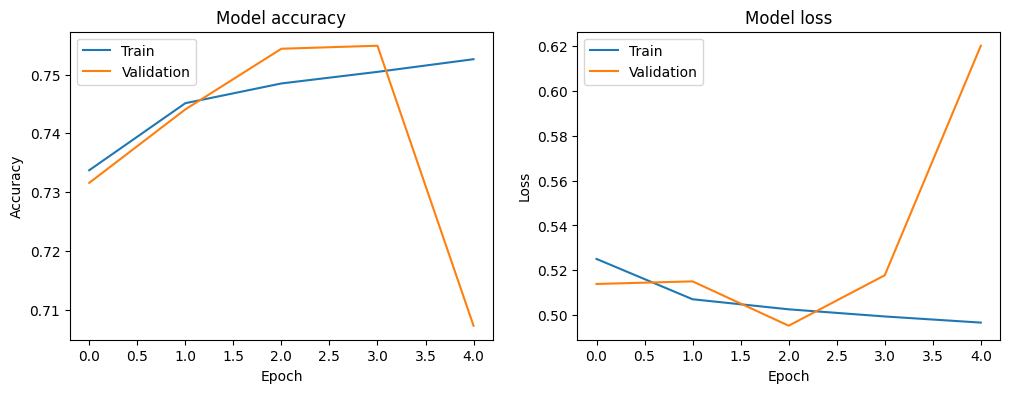

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Additional testing

In [34]:
data = pd.read_csv("./rotten_tomatoes_critic_reviews.csv")
data.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [35]:
# Drop missing review_content rows
data = data.dropna(subset=['review_content'])

# Only use review_type (result) and review_content columns
data = data[['review_type', 'review_content']]

# Encode sentiment
data['sentiment'] = data['review_type'].apply(lambda x: 1 if x == 'Fresh' else 0)

data.head()

,review_type,review_content,sentiment
0,Fresh,A fantasy adventure that fuses Greek mythology...,1
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,Fresh,With a top-notch cast and dazzling special eff...,1
3,Fresh,Whether audiences will get behind The Lightnin...,1
4,Rotten,What's really lacking in The Lightning Thief i...,0


In [36]:
# Extract texts and labels
texts = data['review_content'].values
labels = data['sentiment'].values

# Text tokenizing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad sequences
data = pad_sequences(sequences, maxlen=max_len)

# Convert labels to categorical
labels = to_categorical(np.asarray(labels))

In [37]:
# Evaluate model
score = model.evaluate([data, data], labels)
print(f"Test accuracy: {score[1]}")

33257/33257 ━━━━━━━━━━━━━━━━━━━━ 463s 14ms/step - accuracy: 0.5806 - loss: 0.7253
Test accuracy: 0.5865838527679443


2024-06-24 01:42:50.079206: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Results from the additional testing dataset:

| Model | Accuracy | Loss |
| --- | --- | --- |
| Initial model (64/128) | 0.5530 | 1.0205 |
| Bigger model (128/256) with Batch Normalization and Dropout + Filtered content for training | 0.5806 | 0.7253 |